# Sample MERRA-2 at IMPROVE Sites
This is an example showing how to use GMAOpyobs utilities to read IMPROVE surface observations data, sample MERRA-2, and do a simple comparison.

This assumes that you have cloned the GMAOpyobs Github repository, installed it in a directory called `$AERODIR`, and have added the following path to your `$PYTHONPATH` environment variable:
`$AERODIR/install/lib/Python`

It also assumes you have a grads style control file for the MERRA-2 files. An example of such a file is in this directory called `inst3_3d_aer_Nv`, and it points to files in a directory called `MERRA2_all` also in this directory. 
The full path to `MERRA2_all` on discover is `/discover/nobackup/projects/gmao/merra2/data/products/MERRA2_all`.

To create the `MERRA2_all` directory in the current directory, create a symbolic link:
`ln -s /discover/nobackup/projects/gmao/merra2/data/products/MERRA2_all .`

The `inst3_3d_aer_Nv` MERRA-2 file collection contains 3-D aerosol mass mixing ratios on the native model vertical levels.

This example also requires GEOS aerosol optics files as inputs.  These files can be found at `https://portal.nccs.nasa.gov/datashare/iesa/aerosol/ExtData/` or on discover at `/discover/nobackup/projects/gmao/share/dasilva/fvInput/ExtData`

The IMROVE data was downloaded from `https://views.cira.colostate.edu/fed/DataFiles/` and can found on discover at `/discover/nobackup/projects/gmao/iesa/aerosol/data/AeroObs/IMPROVE`

## IMPROVE Station Sampling

In [1]:
# If you using discover JupyterHub, make sure to use the latest GEOSpyd kernel
# Add a kernel to your Jupyterhub by executing the following on discover:
# python3 -m ipykernel install --user --name GEOSpyD-24.11.3-3.13 --display-name "GEOSpyD 24.11.3 3.13"
# restart Jupyterhub and the new kernel should be available

# You only need to do these first three lines if you're using the discover JupyterHub
# replace the AERODIR path with your install location for GMAOpyobs
import sys
AERODIR = '/discover/nobackup/pcastell/workspace/GMAOpyobs_improve_update/GMAOpyobs'
sys.path.append(AERODIR+'/install/lib/Python')

from pyobs.sampler import STATION
from pyobs.improve import IMPROVE,SITE_MAP
from datetime import datetime

In [2]:
## Read the IMPROVE locations file
#site_path = '/discover/nobackup/projects/gmao/iesa/aerosol/data/AeroObs/IMPROVE/IMPROVE_locations.txt'
site_path = '/Users/pcastell/Documents/Asia-AQ/IMPROVE/improve/IMPROVE_locations.txt'
sites = SITE_MAP(site_path)

In [ ]:
## set the time range you want to consider
time_range = [datetime(2015,7,1),datetime(2015,7,5)]

## Create a station object with aerosol data
m2data = ['inst3_3d_aer_Nv']  # MERRA-2 collection ctrl files
stn = STATION(sites.df['SiteCode'],sites.df['Longitude'],sites.df['Latitude'],m2data,time_range=time_range,verbose=True)

In [4]:
## Sample the MERRA-2 dataset at the stations, and return an xarray dataset
# on Jupyterhub this will take a minute - stand up, get a cup of coffee
# on the command line, this takes ~7 seconds

# Variables I want to read
du = ['DU001','DU002','DU003','DU004','DU005']
ss = ['SS001','SS002','SS003','SS004','SS005']
bc = ['BCPHILIC','BCPHOBIC']
oc = ['OCPHILIC','OCPHOBIC']
su = ['SO4']
met = ['AIRDENS','DELP','PS','RH']
Variables = met + du + ss + bc + oc + su

stn_ds = stn.sample(Variables=Variables).compute()

[ ] sampling  AIRDENS
[ ] sampling  DELP
[ ] sampling  PS
[ ] sampling  RH
[ ] sampling  DU001
[ ] sampling  DU002
[ ] sampling  DU003
[ ] sampling  DU004
[ ] sampling  DU005
[ ] sampling  SS001
[ ] sampling  SS002
[ ] sampling  SS003
[ ] sampling  SS004
[ ] sampling  SS005
[ ] sampling  BCPHILIC
[ ] sampling  BCPHOBIC
[ ] sampling  OCPHILIC
[ ] sampling  OCPHOBIC
[ ] sampling  SO4


In [5]:
## optional: you can write sampled data to a netcdf file
outFile = 'm2_improve_sampled.nc4'
comp = dict(zlib=True)
encoding = {var: comp for var in stn_ds.data_vars}
stn_ds.to_netcdf(outFile,engine='netcdf4',encoding=encoding)

# Calculate Modeled PM2.5 Comparable to IMPROVE Observations
Now that we have the 3-D aerosol mass mixing ratios, we would like to convert this to surface PM2.5 like what is measured by IMPROVE.

You will need the aerosol optics tables, and a yaml file describing which files to use.

The yaml file used here is called `m2_pm25.yaml` can be found in the  directory `GMAOpyobs/src/config`. 

It points to optics files located in the directory `ExtData`.

On discover, to create an `ExtData` directory in the current dirctory, create a symbolic link:

`ln -s /discover/nobackup/projects/gmao/share/dasilva/fvInput/ExtData .`


In [30]:
import xarray as xr
outFile = 'm2_improve_sampled.nc4'
stn_ds = xr.open_dataset(outFile)

In [33]:
from pyobs.aop import G2GAOP

# set up some filenames
# this configuration file can be found in src/config
config = 'm2_pm25.yaml'

In [34]:
# Create an optics object that links the model optics tables to the sampled aerosol profile data
optics = G2GAOP(stn_ds,config=config)
# ignore the phase matrix warning - not relevant here

In [91]:
# calculate PM2.5 per species
pm25 = {}
for spc in optics.mieTable:
    pm25[spc] = optics.getPM(Species=[spc],pmsize=2.5,aerodynamic=True)
    # add the dry mass, we will be comparing to that later
    pmdry = pm25[spc]['PM']*(1-pm25[spc]['FWATER'])
    attrs = {'long_name':'Dry Particulate Matter Mass', 'units':'microgram m-3'}
    pmdry.attrs.update(attrs)
    pm25[spc]['PMDRY'] = pmdry

spc = 'TOTAL'
pm25[spc] = optics.getPM(pmsize=2.5,aerodynamic=True)
# add the dry mass, we will be comparing to that later
pmdry = pm25[spc]['PM']*(1-pm25[spc]['FWATER'])
attrs = {'long_name':'Dry Particulate Matter Mass', 'units':'microgram m-3'}
pmdry.attrs.update(attrs)
pm25[spc]['PMDRY'] = pmdry

In [92]:
# optional: you can write this to a netcdf file
comp = dict(zlib=True)
for spc in pm25:
    outFile = f'm2_improve_pm25_{spc}.nc4'
    print('writing ',outFile)
    encoding = {var: comp for var in pm25[spc].data_vars}
    pm25[spc].to_netcdf(outFile,engine='netcdf4',encoding=encoding)

writing  m2_improve_pm25_DU.nc4
writing  m2_improve_pm25_SS.nc4
writing  m2_improve_pm25_OC.nc4
writing  m2_improve_pm25_BC.nc4
writing  m2_improve_pm25_SU.nc4
writing  m2_improve_pm25_TOTAL.nc4


## Compare MERRA-2 PM2.5 to IMPROVE Observations

In [37]:
from pyobs.improve import IMPROVE, SITE_MAP
## Read the IMPROVE PM2.5 Obs
#path = '/discover/nobackup/projects/gmao/iesa/aerosol/data/AeroObs/IMPROVE/IMPAER_2015.txt'
#site_path = '/discover/nobackup/projects/gmao/iesa/aerosol/data/AeroObs/IMPROVE/IMPROVE_locations.txt'
path = '/Users/pcastell/Documents/Asia-AQ/IMPROVE/improve/IMPAER_2015.txt'
site_path = '/Users/pcastell/Documents/Asia-AQ/IMPROVE/improve/IMPROVE_locations.txt'
imp = IMPROVE(path,site_path=site_path)
sites = SITE_MAP(site_path)

In [38]:
imp.df

,SiteCode,POC,Date,ParamCode,MethodID,Units,pm25,Status,ProviderStatus,F2,F3,error,MDL,Start_Time,Longitude,Latitude,tz_name,Start_Time_UTC
0,ACAD1,1,2015-01-03,ALf,1001,ug/m^3,0.01455,V0,NM,---,---,0.00176,0.00193,2015-01-03,-68.2610,44.3771,America/New_York,2015-01-03 05:00:00+00:00
1,ACAD1,1,2015-01-03,ammNO3f,905,ug/m^3,0.18060,V0,NM,---,---,-999.00000,-999.00000,2015-01-03,-68.2610,44.3771,America/New_York,2015-01-03 05:00:00+00:00
2,ACAD1,1,2015-01-03,ammSO4f,903,ug/m^3,0.66358,V0,NM,---,---,-999.00000,-999.00000,2015-01-03,-68.2610,44.3771,America/New_York,2015-01-03 05:00:00+00:00
3,ACAD1,1,2015-01-03,ASf,1001,ug/m^3,0.00027,V0,NM,---,---,0.00015,0.00022,2015-01-03,-68.2610,44.3771,America/New_York,2015-01-03 05:00:00+00:00
4,ACAD1,1,2015-01-03,BRf,1001,ug/m^3,0.00178,V0,NM,---,---,0.00020,0.00014,2015-01-03,-68.2610,44.3771,America/New_York,2015-01-03 05:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254603,ZICA1,1,2015-12-29,TCf,918,ug/m^3,-999.00000,M1,DA,RT,C,-999.00000,-999.00000,2015-12-29,-113.1508,37.1983,America/Denver,2015-12-29 07:00:00+00:00
1254604,ZICA1,1,2015-12-29,TIf,1001,ug/m^3,0.00103,V0,NM,RT,A,0.00023,0.00033,2015-12-29,-113.1508,37.1983,America/Denver,2015-12-29 07:00:00+00:00
1254605,ZICA1,1,2015-12-29,Vf,1001,ug/m^3,0.00007,V0,NM,RT,A,0.00007,0.00011,2015-12-29,-113.1508,37.1983,America/Denver,2015-12-29 07:00:00+00:00
1254606,ZICA1,1,2015-12-29,ZNf,1001,ug/m^3,0.00081,V0,NM,RT,A,0.00024,0.00038,2015-12-29,-113.1508,37.1983,America/Denver,2015-12-29 07:00:00+00:00


In [93]:
# IMPROVE measures 24 hour average PM2.5 from midnight to midnight local time
# get the daily averages at each site
from datetime import datetime,timedelta
import pytz

time_range = [datetime(2015,7,1),datetime(2015,7,5)]
pm25_daily = {}
for spc in pm25:
    print(spc)
    tstart = time_range[0]
    tend = time_range[1]
    ds = pm25[spc]
    ds_daily = []
    while tstart < tend:
        print(tstart)
        ds_avg = []
        for site in sites.df['SiteCode']:
            timezone_name = sites.df[sites.df['SiteCode'] == site]['tz_name'].item()
            if timezone_name:
                local_timezone = pytz.timezone(timezone_name)
                time_aware_local = local_timezone.localize(tstart, is_dst=False)
                time_utc = time_aware_local.astimezone(pytz.utc).replace(tzinfo=None)
                ds_new = ds.sel(station=site).sel(time=slice(time_utc,time_utc+timedelta(hours=24))).mean(dim='time')
                ds_new = ds_new.assign_coords(time=[tstart])
                ds_avg.append(ds_new)

        ds_avg = xr.concat(ds_avg,dim='station',coords="different",compat='equals')
        ds_daily.append(ds_avg)

        tstart += timedelta(days=1)

    pm25_daily[spc] = xr.concat(ds_daily,dim='time',coords="different",compat='equals',data_vars='all')


DU
2015-07-01 00:00:00
2015-07-02 00:00:00
2015-07-03 00:00:00
2015-07-04 00:00:00
SS
2015-07-01 00:00:00
2015-07-02 00:00:00
2015-07-03 00:00:00
2015-07-04 00:00:00
OC
2015-07-01 00:00:00
2015-07-02 00:00:00
2015-07-03 00:00:00
2015-07-04 00:00:00
BC
2015-07-01 00:00:00
2015-07-02 00:00:00
2015-07-03 00:00:00
2015-07-04 00:00:00
SU
2015-07-01 00:00:00
2015-07-02 00:00:00
2015-07-03 00:00:00
2015-07-04 00:00:00
TOTAL
2015-07-01 00:00:00
2015-07-02 00:00:00
2015-07-03 00:00:00
2015-07-04 00:00:00


In [41]:
pm25_daily['SU']

<xarray.Dataset> Size: 2MB
Dimensions:  (time: 4, station: 234, lev: 72)
Coordinates:
  * time     (time) datetime64[ns] 32B 2015-07-01 2015-07-02 ... 2015-07-04
  * station  (station) <U5 5kB 'ACAD1' 'ADPI1' 'AGTI1' ... 'ZION1' 'ZICA1'
  * lev      (lev) float64 576B 1.0 2.0 3.0 4.0 5.0 ... 68.0 69.0 70.0 71.0 72.0
    lon      (station) float64 2kB -68.26 -77.21 -117.0 ... -119.7 -113.2 -113.2
    lat      (station) float64 2kB 44.38 42.09 33.46 67.1 ... 37.71 37.46 37.2
Data variables:
    PM       (time, station, lev) float32 270kB 1.517e-18 9.633e-18 ... 7.529
    FWATER   (time, station, lev) float32 270kB 0.001235 0.001575 ... 0.5712
    DELP     (time, station, lev) float64 539kB 1.0 1.27 ... 1.132e+03 1.243e+03
    AIRDENS  (time, station, lev) float64 539kB 2.78e-05 4.869e-05 ... 0.9653
    PMDRY    (time, station, lev) float32 270kB 1.516e-18 9.619e-18 ... 3.071

In [42]:
# convert IMPROVE dataframe to xarray dataset for easier comparisons
df = imp.df.rename(columns={'SiteCode':'station','Start_Time':'time','Longitude':'lon','Latitude':'lat'})
df = df.set_index(['time','station','ParamCode'])
print(f"Original length: {len(df.index)}")
print(f"Unique index length: {len(df.index.unique())}")
# there  can be duplicate entries because there are multiple instruments at one site
# let's just keep the first measurement in the database
df_unique = df[~df.index.duplicated(keep='first')]
# Now convert the cleaned DataFrame to xarray
imp_ds = df_unique.to_xarray()
imp_ds


Original length: 1254608
Unique index length: 1146894


<xarray.Dataset> Size: 170MB
Dimensions:         (time: 121, station: 172, ParamCode: 68)
Coordinates:
  * time            (time) datetime64[ns] 968B 2015-01-03 ... 2015-12-29
  * station         (station) object 1kB 'ACAD1' 'AGTI1' ... 'YOSEX' 'ZICA1'
  * ParamCode       (ParamCode) object 544B 'ALf' 'ASf' ... 'ammSO4f' 'fAbs'
Data variables: (12/15)
    POC             (time, station, ParamCode) float64 11MB 1.0 1.0 ... 1.0 1.0
    Date            (time, station, ParamCode) object 11MB '2015-01-03' ... '...
    MethodID        (time, station, ParamCode) float64 11MB 1.001e+03 ... 1.6...
    Units           (time, station, ParamCode) object 11MB 'ug/m^3' ... '1/Mm'
    pm25            (time, station, ParamCode) float64 11MB 0.01455 ... 0.8
    Status          (time, station, ParamCode) object 11MB 'V0' 'V0' ... 'V0'
    ...              ...
    error           (time, station, ParamCode) float64 11MB 0.00176 ... 0.16
    MDL             (time, station, ParamCode) float64 11MB 0.00193 ... 0.35
    lon             (time, station, ParamCode) float64 11MB -68.26 ... -113.2
    lat             (time, station, ParamCode) float64 11MB 44.38 44.38 ... 37.2
    tz_name         (time, station, ParamCode) object 11MB 'America/New_York'...
    Start_Time_UTC  (time, station, ParamCode) object 11MB 2015-01-03T05:00:0...

In [85]:
## Create a little plotting function
import matplotlib.pyplot as plt
def compare_imp_m2(imsubset,m2subset,species):
    im = plt.plot(imsubset['pm25'],m2subset['PMDRY'],'o')

    # Get the range for the 1:1 line
    min_val = min(imsubset['pm25'].min(), m2subset['PMDRY'].min())
    max_val = max(imsubset['pm25'].max(), m2subset['PMDRY'].max())

    # Add 1:1 line
    line = plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='1:1 line')

    # Add labels and formatting
    plt.xlabel(f'IMPROVE {species} PM2.5')
    plt.ylabel(f'MERRA-2 {species} PM2.5')
    plt.title(f'IMPROVE vs MERRA-2 {species} Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()



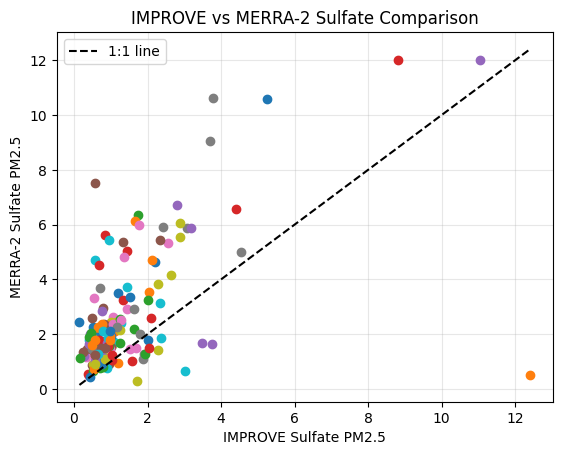

In [86]:
## Compare Ammonium Sulfate
import numpy as np

m2spc = 'SU'
imspc = 'ammSO4f'
m2 = pm25_daily[m2spc]
im = imp_ds.sel(ParamCode=imspc)

# subset improve data for time period of model
valid_times = im.time.values[np.isin(im.time.values, m2.time.values)]
valid_stations = m2.station.values[np.isin(m2.station.values, im.station.values)]
imsubset = im.sel(
    time=valid_times,
    station=valid_stations
)
# repalce -999 with nan
imsubset = imsubset.where(imsubset != -999.)

# subset model for stations in IMPROVE dataset
# and at the surface
m2subset = m2.sel(
    time=valid_times,
    station=valid_stations,
    lev=72,
)

compare_imp_m2(imsubset,m2subset,'Sulfate')


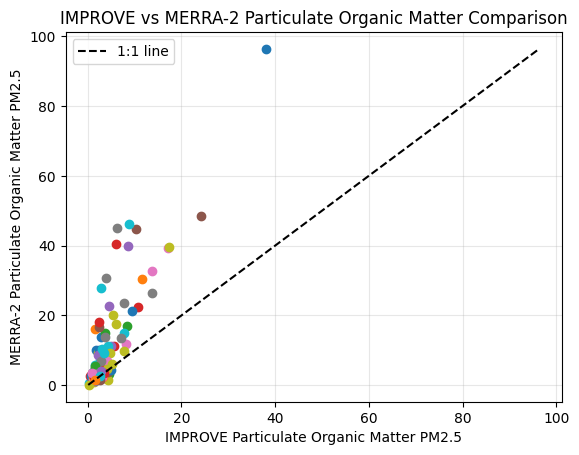

In [87]:
# Organic Carbon or particulate organic matter
# in GEOS a factor of 1.8 is already applied to convert source masses
# of organic carbon into particulate organic matter
m2spc = 'OC'
imspc = 'OMCf'
m2 = pm25_daily[m2spc]
im = imp_ds.sel(ParamCode=imspc)

# subset improve data for time period of model
valid_times = im.time.values[np.isin(im.time.values, m2.time.values)]
valid_stations = m2.station.values[np.isin(m2.station.values, im.station.values)]
imsubset = im.sel(
    time=valid_times,
    station=valid_stations
)
# repalce -999 with nan
imsubset = imsubset.where(imsubset != -999.)

# subset model for stations in IMPROVE dataset
# and at the surface
m2subset = m2.sel(
    time=valid_times,
    station=valid_stations,
    lev=72,
)

compare_imp_m2(imsubset,m2subset,'Particulate Organic Matter')


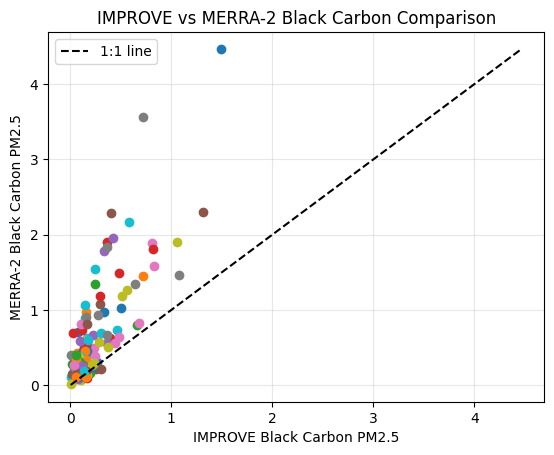

In [88]:
# Black Carbon or elemental carbon
m2spc = 'BC'
imspc = 'ECf'
m2 = pm25_daily[m2spc]
im = imp_ds.sel(ParamCode=imspc)

# subset improve data for time period of model
valid_times = im.time.values[np.isin(im.time.values, m2.time.values)]
valid_stations = m2.station.values[np.isin(m2.station.values, im.station.values)]
imsubset = im.sel(
    time=valid_times,
    station=valid_stations
)
# repalce -999 with nan
imsubset = imsubset.where(imsubset != -999.)

# subset model for stations in IMPROVE dataset
# and at the surface
m2subset = m2.sel(
    time=valid_times,
    station=valid_stations,
    lev=72,
)

compare_imp_m2(imsubset,m2subset,'Black Carbon')

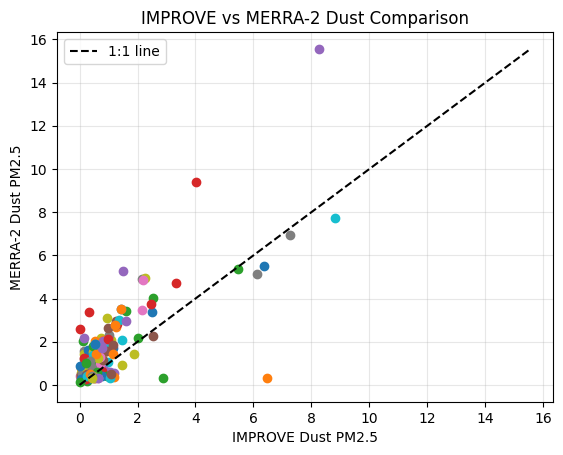

In [89]:
# Dust or soil
m2spc = 'DU'
imspc = 'SOILf'
m2 = pm25_daily[m2spc]
im = imp_ds.sel(ParamCode=imspc)

# subset improve data for time period of model
valid_times = im.time.values[np.isin(im.time.values, m2.time.values)]
valid_stations = m2.station.values[np.isin(m2.station.values, im.station.values)]
imsubset = im.sel(
    time=valid_times,
    station=valid_stations
)
# repalce -999 with nan
imsubset = imsubset.where(imsubset != -999.)

# subset model for stations in IMPROVE dataset
# and at the surface
m2subset = m2.sel(
    time=valid_times,
    station=valid_stations,
    lev=72,
)

compare_imp_m2(imsubset,m2subset,'Dust')

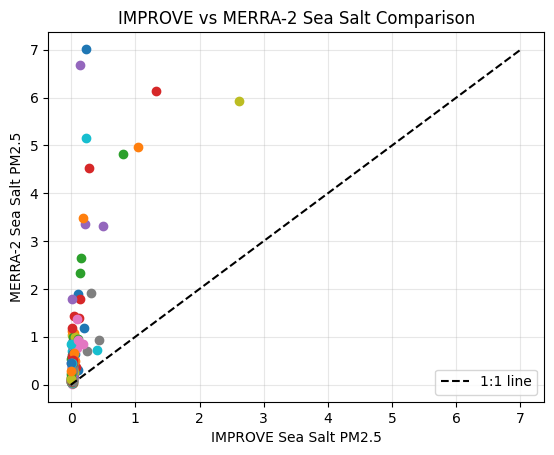

In [90]:
# Sea Salt
m2spc = 'SS'
imspc = 'SeaSaltf'
m2 = pm25_daily[m2spc]
im = imp_ds.sel(ParamCode=imspc)

# subset improve data for time period of model
valid_times = im.time.values[np.isin(im.time.values, m2.time.values)]
valid_stations = m2.station.values[np.isin(m2.station.values, im.station.values)]
imsubset = im.sel(
    time=valid_times,
    station=valid_stations
)
# repalce -999 with nan
imsubset = imsubset.where(imsubset != -999.)

# subset model for stations in IMPROVE dataset
# and at the surface
m2subset = m2.sel(
    time=valid_times,
    station=valid_stations,
    lev=72,
)

compare_imp_m2(imsubset,m2subset,'Sea Salt')

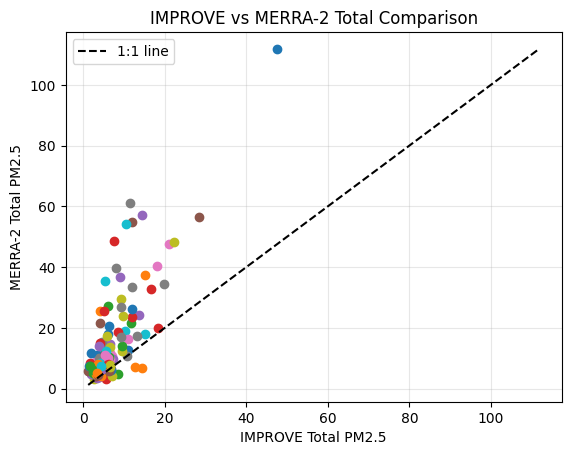

In [94]:
# Total PM2.5
m2spc = 'TOTAL'
imspc = 'RCFM'
m2 = pm25_daily[m2spc]
im = imp_ds.sel(ParamCode=imspc)

# subset improve data for time period of model
valid_times = im.time.values[np.isin(im.time.values, m2.time.values)]
valid_stations = m2.station.values[np.isin(m2.station.values, im.station.values)]
imsubset = im.sel(
    time=valid_times,
    station=valid_stations
)
# repalce -999 with nan
imsubset = imsubset.where(imsubset != -999.)

# subset model for stations in IMPROVE dataset
# and at the surface
m2subset = m2.sel(
    time=valid_times,
    station=valid_stations,
    lev=72,
)

compare_imp_m2(imsubset,m2subset,'Total')